In [36]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_io as tfio

In [2]:
tfds.list_builders()

2024-06-15 15:45:24.358471: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bot_adversarial_dialogue',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar100_n',
 'cifar10_1',
 'cifar10_corrupted',
 'cifar10_h',
 'cifar10_n',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'conll2002',
 

In [3]:
version = 3 # just 3 is available
ds = tfds.load(f'speech_commands:0.0.{version}')
train = ds['train']
validation = ds['validation']
test = ds['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/85511 [00:00<?, ? examples/s]

Shuffling /Users/almog/tensorflow_datasets/speech_commands/0.0.3.incompleteGEAQ2S/speech_commands-train.tfreco…

Generating validation examples...:   0%|          | 0/10102 [00:00<?, ? examples/s]

Shuffling /Users/almog/tensorflow_datasets/speech_commands/0.0.3.incompleteGEAQ2S/speech_commands-validation.t…

Generating test examples...:   0%|          | 0/4890 [00:00<?, ? examples/s]

Shuffling /Users/almog/tensorflow_datasets/speech_commands/0.0.3.incompleteGEAQ2S/speech_commands-test.tfrecor…

Dataset speech_commands downloaded and prepared to /Users/almog/tensorflow_datasets/speech_commands/0.0.3. Subsequent calls will reuse this data.


2024-06-15 16:27:07.692745: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-15 16:27:07.692844: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-06-15 16:27:07.692852: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-06-15 16:27:07.693269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 16:27:07.693665: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [1]:
for example in train.take(2):
    raw_audio = example['audio'].numpy()
    print(example)

NameError: name 'train' is not defined

In [11]:
# play audio
from IPython.display import Audio
Audio(raw_audio, rate=16000)

In [12]:
#load data set info
info = tfds.builder(f'speech_commands:0.0.{version}').info

In [13]:
info

tfds.core.DatasetInfo(
    name='speech_commands',
    full_name='speech_commands/0.0.3',
    description="""
    An audio dataset of spoken words designed to help train and evaluate keyword
    spotting systems. Its primary goal is to provide a way to build and test small
    models that detect when a single word is spoken, from a set of ten target words,
    with as few false positives as possible from background noise or unrelated
    speech. Note that in the train and validation set, the label "unknown" is much
    more prevalent than the labels of the target words or background noise. One
    difference from the release version is the handling of silent segments. While in
    the test set the silence segments are regular 1 second files, in the training
    they are provided as long segments under "background_noise" folder. Here we
    split these background noise into 1 second clips, and also keep one of the files
    for the validation set.
    """,
    homepage='https://arxiv.or

In [15]:
# get the list of labels
labels = info.features['label'].names
# get the number of labels
num_labels = info.features['label'].num_classes
# print the labels with their corresponding index
for i, label in enumerate(labels):
    print(f'{i}: {label}')

0: down
1: go
2: left
3: no
4: off
5: on
6: right
7: stop
8: up
9: yes
10: _silence_
11: _unknown_


In [16]:
# get the number of examples in the train, validation and test sets
num_train = info.splits['train'].num_examples
num_validation = info.splits['validation'].num_examples
num_test = info.splits['test'].num_examples
num_train, num_validation, num_test

(85511, 10102, 4890)

In [17]:
# Constants
SAMPLE_RATE = 16000
DURATION = 1  # 1 second
NUM_MFCC = 13  # Number of MFCC features

In [27]:
# make ds to be ds, label
train_labeled = train.map(lambda x: (x['audio'], x['label']))
validation_labeled = validation.map(lambda x: (x['audio'], x['label']))
test_labeled = test.map(lambda x: (x['audio'], x['label']))


In [32]:
for example in train_labeled.take(1):
    raw_audio_tensor = example[0]
    print(example[1].numpy())

4


2024-06-15 19:25:01.064123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


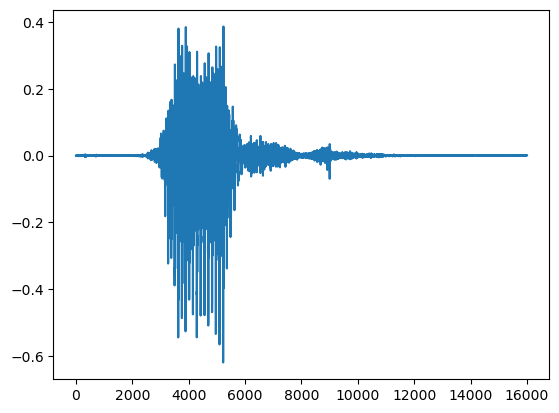

In [34]:
import matplotlib.pyplot as plt
# plot the raw audio signal
tensor = tf.cast(raw_audio_tensor, tf.float32) / 32768.0
plt.figure()
plt.plot(tensor.numpy())

In [43]:
# Trim the noise from the beginning and the end of the audio signal
position = tfio.audio.trim(tensor, axis=0, epsilon=0.05)
print(position)
start = position[0]
stop = position[1]
print(start, stop)

tf.Tensor([3001 6544], shape=(2,), dtype=int64)
tf.Tensor(3001, shape=(), dtype=int64) tf.Tensor(6544, shape=(), dtype=int64)


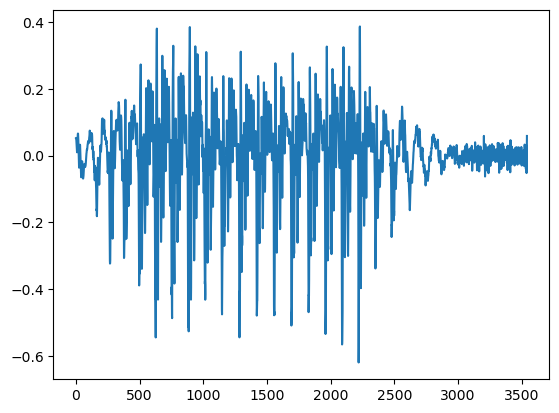

In [44]:
processed = tensor[start:stop]
plt.figure()
plt.plot(processed.numpy())

In [47]:
# play the original audio
print('Original audio')
Audio(tensor.numpy(), rate=SAMPLE_RATE)

Original audio


In [48]:
# play the processed audio
print('Processed audio')
Audio(processed.numpy(), rate=SAMPLE_RATE)

Processed audio


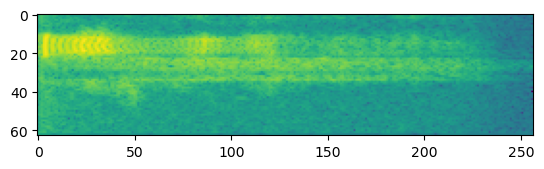

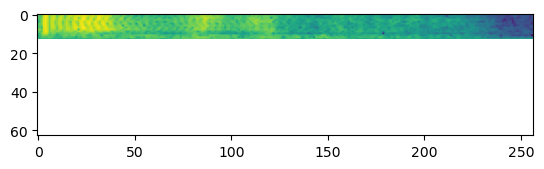

In [57]:
# Convert to spectrogram
original_spectrogram = tfio.audio.spectrogram(
    tensor, nfft=512, window=512, stride=256)

plt.figure()
plt.imshow(tf.math.log(original_spectrogram).numpy())

processed_spectrogram = tfio.audio.spectrogram(processed, nfft=512, window=512, stride=256)
plt.figure()
plt.imshow(tf.math.log(processed_spectrogram).numpy())

In [56]:
# fill processed_audio with zeros
padded_processed_audio = tf.pad(processed, paddings=[[0, SAMPLE_RATE - tf.shape(processed)[0]]], mode='CONSTANT', constant_values=0)
Audio(padded_processed_audio.numpy(), rate=SAMPLE_RATE)

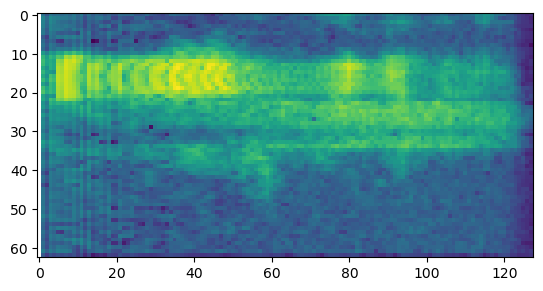

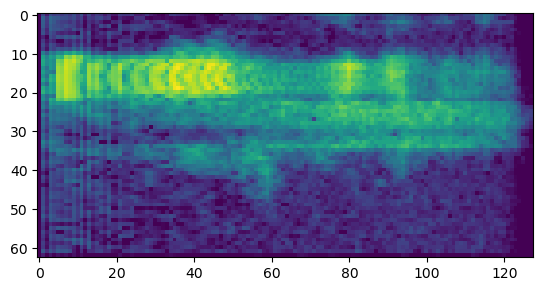

In [61]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    original_spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())